<a href="https://colab.research.google.com/github/daquarti/AI/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.menos de 48hs de evolución
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/computer_vision/segmentation/train"

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import fastai
# fastai.torch_core.defaults.device = 'cpu'

In [ ]:
insulators = Path(path)
#codes = np.loadtxt(insulators/"codes.txt", dtype=str); codes
label = insulators/"masks"
image = insulators/"images"
get_y = lambda x: label/f"{x.stem}.png"

## Data

In [ ]:
fnames = get_image_files(image)
fnames[:3]

[PosixPath('/content/drive/My Drive/computer_vision/segmentation/train/images/4f62a5bb14.png'),
 PosixPath('/content/drive/My Drive/computer_vision/segmentation/train/images/df8d9625c0.png'),
 PosixPath('/content/drive/My Drive/computer_vision/segmentation/train/images/7a0f1e9b45.png')]

In [ ]:
lbl_names = get_image_files(label)
lbl_names[:3]

[PosixPath('/content/drive/My Drive/computer_vision/segmentation/train/masks/c72c5ee731.png'),
 PosixPath('/content/drive/My Drive/computer_vision/segmentation/train/masks/6397715bb4.png'),
 PosixPath('/content/drive/My Drive/computer_vision/segmentation/train/masks/9f54d7807c.png')]

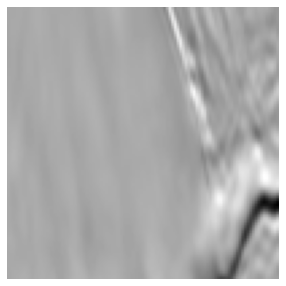

In [ ]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: label/f"{x.stem}.png"

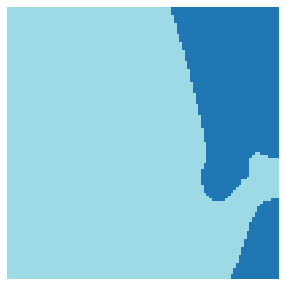

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([101, 101]), tensor([[[255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0],
          ...,
          [255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0]]]))

In [ ]:
#codes = np.loadtxt(insulators/'codes.txt', dtype=str); codes

In [ ]:
codes = np.array(['fondo', 'riñon'], dtype='<U17'); codes

array(['fondo', 'riñon'], dtype='<U17')

## Datasets

In [ ]:
size = (256,256)#src_size//2
print(size)
bs=2
# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

(256, 256)


In [ ]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

src = (SegItemListCustom.from_folder(image)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes) )

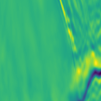

In [ ]:
open_mask(fnames[2])

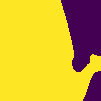

In [ ]:
open_mask(get_y_fn(fnames[2]))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True )
        .databunch(bs=bs)
        .normalize(imagenet_stats))

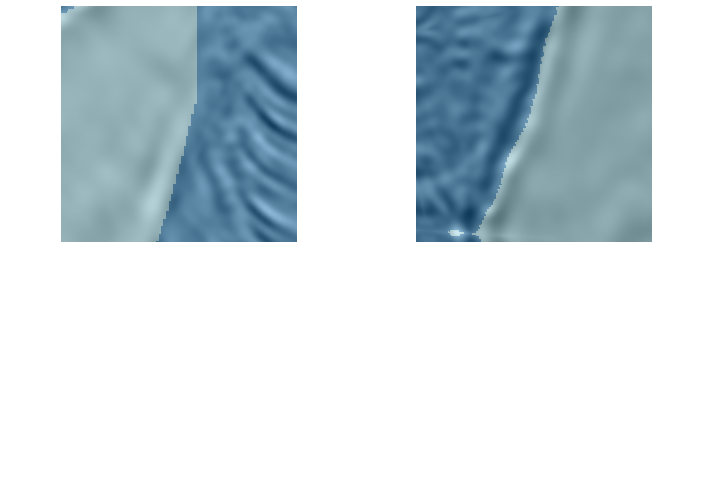

In [ ]:
data.show_batch(5, figsize=(10,7))

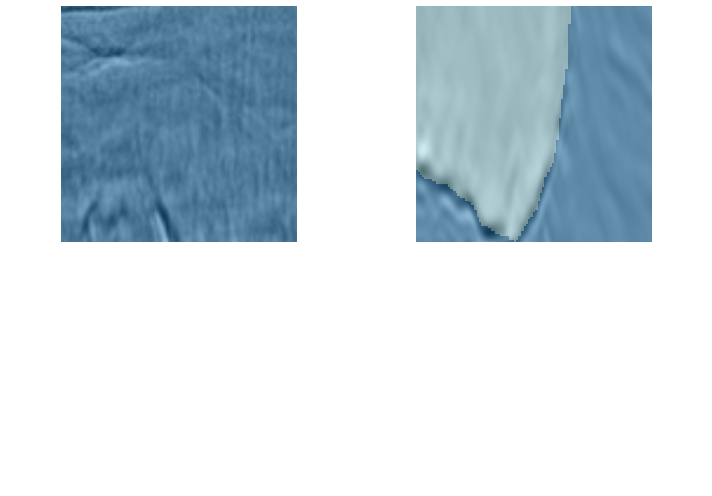

In [ ]:
data.show_batch(5, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
# void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
#     mask = target != void_code
    return (input.argmax(dim=1)==target).float().mean()

{'fondo': 0, 'riñon': 1}


In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
data.classes

array(['fondo', 'riñon'], dtype='<U17')

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


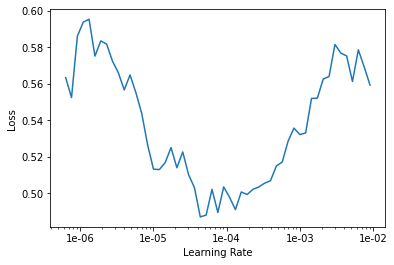

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-5

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.521669,0.456663,0.813783,12:58
1,0.408745,0.397625,0.847361,03:26
2,0.416810,0.347580,0.867413,03:25
3,0.372901,0.330797,0.876201,03:25
4,0.309429,0.305639,0.882698,03:25
5,0.295999,0.294488,0.890390,03:24
6,0.275018,0.285865,0.888557,03:24
7,0.262642,0.294243,0.884990,03:24
8,0.257370,0.254608,0.905793,03:24
9,0.283707,0.249990,0.905766,03:24


In [ ]:
learn.save(path + 'stage-1')

In [ ]:
learn.load(path + 'stage-1');

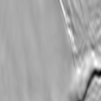

In [ ]:
img = open_image(fnames[2])

In [ ]:
prediction = learn.predict(img)

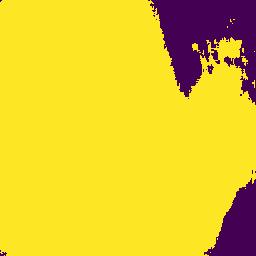

In [ ]:
prediction[0]

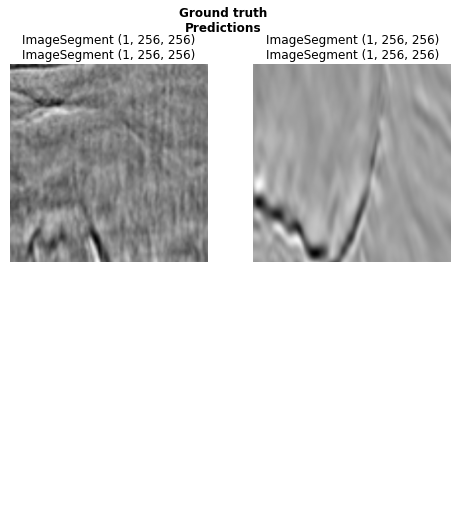

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


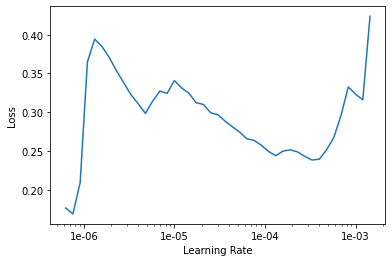

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-5
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.254082,0.266143,0.898453,03:48
1,0.251229,0.249441,0.905741,03:48
2,0.239248,0.268535,0.900043,03:49
3,0.226208,0.244439,0.908817,03:49
4,0.250319,0.240543,0.909663,03:49
5,0.221214,0.236611,0.910284,03:49
6,0.191557,0.231051,0.913611,03:49
7,0.271605,0.244579,0.908246,03:49
8,0.202381,0.249055,0.908769,03:49
9,0.221913,0.239881,0.909979,03:49


In [ ]:
learn.save(path + 'stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
#learn.destroy() # uncomment once 1.0.46 is out

size = (512, 512)

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-6

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
img = open_image('/home/drones/fastai/caravan/image/4df1536de792_11.jpg')

In [ ]:
prediction = learn.predict(img)[0]

In [ ]:
prediction